In [2]:
import torch
import torch.nn as nn
from torcheval.metrics import FrechetInceptionDistance
from torchvision import transforms

In [3]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import numpy as np


class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""

    def __init__(self, embed_dim, scale=30.0):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(
            channels[3], channels[2], 3, stride=2, bias=False
        )
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(
            channels[2] + channels[2],
            channels[1],
            3,
            stride=2,
            bias=False,
            output_padding=1,
        )
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(
            channels[1] + channels[1],
            channels[0],
            3,
            stride=2,
            bias=False,
            output_padding=1,
        )
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))
        # Encoding path
        h1 = self.conv1(x)
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [4]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016,
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [5]:
import matplotlib.pyplot as plt
from torchvision import datasets, utils
from tqdm.auto import tqdm


class DDPM(nn.Module):
    def __init__(
        self,
        network,
        predict_using="epsilon",
        scheduler_method="linear",
        variance_reduction="none",
        T=100,
        beta_1=1e-4,
        beta_T=2e-2,
    ):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (
            self._network(x.reshape(-1, 1, 28, 28), (t.squeeze() / T))
        ).reshape(-1, 28 * 28)

        # Total number of time steps
        self.T = T

        # Predict using epsilon, mu or x_0
        self.predict_using = predict_using

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T + 1))
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))

    def forward_diffusion(self, x0, t, epsilon):
        """
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        """

        mean = torch.sqrt(self.alpha_bar[t]) * x0
        std = torch.sqrt(1 - self.alpha_bar[t])

        return mean + std * epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        # Eq 11 in Ho et al, 2020
        if self.predict_using == "epsilon":
            mean = (
                1.0
                / torch.sqrt(self.alpha[t])
                * (
                    xt
                    - (self.beta[t])
                    / torch.sqrt(1 - self.alpha_bar[t])
                    * self.network(xt, t)
                )
            )

            std = torch.where(
                t > 0,
                torch.sqrt(
                    ((1 - self.alpha_bar[t - 1]) / (1 - self.alpha_bar[t]))
                    * self.beta[t]
                ),
                0,
            )

        elif self.predict_using == "x0":
            nn_predicted_x0 = self.network(xt, t)  ## NN prediction of x0

            # Index alpha, alpha_bar, alpha_bar_pred,  beta
            alpha_t = self.alpha[t]
            alpha_bar_t = self.alpha_bar[t]
            alpha_bar_prev_t_1 = self.alpha_bar[t - 1]
            beta_t = self.beta[t]

            # Equation 7 in DDPM by Ho et al, 2020
            coefficient_x0 = torch.sqrt(alpha_bar_prev_t_1) / (1 - alpha_bar_t) * beta_t
            coefficient_xt = (
                torch.sqrt(alpha_t) * (1 - alpha_bar_prev_t_1) / (1 - alpha_bar_t)
            )
            mean = coefficient_x0 * nn_predicted_x0 + coefficient_xt * xt

            beta_tilde = ((1 - alpha_bar_prev_t_1) / (1 - alpha_bar_t)) * beta_t
            std = torch.sqrt(beta_tilde)

        elif self.predict_using == "mu":
            mean = self.network(xt, t)

            std = torch.where(
                t > 0,
                torch.sqrt(
                    ((1 - self.alpha_bar[t - 1]) / (1 - self.alpha_bar[t]))
                    * self.beta[t]
                ),
                0,
            )

        return mean + std * epsilon

    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0], 1)).to(x0.device)

        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        if self.predict_using == "epsilon":
            target = epsilon
        elif self.predict_using == "x0":
            target = x0
        elif self.predict_using == "mu":
            target = self.forward_diffusion(x0, t - 1, epsilon)

        return -nn.MSELoss(reduction="none")(target, self.network(xt, t))

    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """

        return -self.elbo_simple(x0).mean()


## end of DDPM class


def train(
    model,
    optimizer,
    scheduler,
    dataloader,
    epochs,
    device,
    ema=True,
    per_epoch_callback=None,
):
    """
    Training loop

    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader) * epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(
            model, device=device, decay=1.0 - ema_alpha
        )

    for epoch in range(epochs):
        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(
                loss=f"⠀{loss.item():12.4f}",
                epoch=f"{epoch + 1}/{epochs}",
                lr=f"{scheduler.get_last_lr()[0]:.2E}",
            )
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter % ema_steps == 0:
                    ema_model.update_parameters(model)

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(
            lambda x: x + torch.rand(x.shape) / 255
        ),  # Dequantize pixel values
        transforms.Lambda(lambda x: (x - 0.5) * 2.0),  # Map from [0,1] -> [-1, -1]
        transforms.Lambda(lambda x: x.flatten()),
    ]
)

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST("./mnist_data", download=True, train=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)


def reporter(model):
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples, 28 * 28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples + 1) / 2
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()


/home/carstenj/dev/pml/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Select device
# Check for CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
# Check for MPS (for Apple Silicon)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: cuda


Training:   1%|          | 234/23500 [00:14<18:55:05,  2.93s/it, epoch=1/100, loss=⠀      0.1845, lr=9.77E-04]

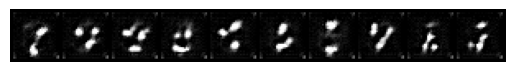

Training:   2%|▏         | 469/23500 [00:31<40:23,  9.50it/s, epoch=2/100, loss=⠀      0.1684, lr=9.54E-04]   

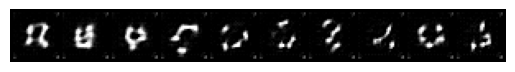

Training:   3%|▎         | 704/23500 [00:47<30:37, 12.41it/s, epoch=3/100, loss=⠀      0.1900, lr=9.32E-04]

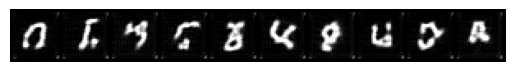

Training:   4%|▍         | 939/23500 [01:04<30:18, 12.41it/s, epoch=4/100, loss=⠀      0.1717, lr=9.10E-04]

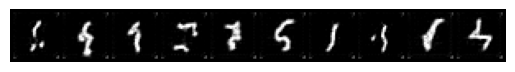

Training:   5%|▍         | 1174/23500 [01:21<15:32:26,  2.51s/it, epoch=5/100, loss=⠀      0.1501, lr=8.89E-04]

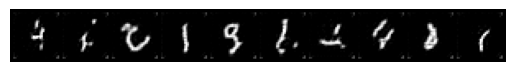

Training:   6%|▌         | 1409/23500 [01:37<50:07,  7.35it/s, epoch=6/100, loss=⠀      0.1659, lr=8.68E-04]   

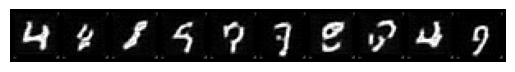

Training:   7%|▋         | 1644/23500 [01:54<29:42, 12.26it/s, epoch=7/100, loss=⠀      0.1740, lr=8.48E-04]

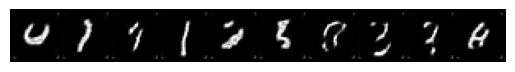

Training:   8%|▊         | 1879/23500 [02:10<26:27, 13.62it/s, epoch=8/100, loss=⠀      0.1715, lr=8.29E-04]

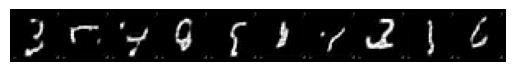

Training:   9%|▉         | 2114/23500 [02:26<23:03, 15.46it/s, epoch=9/100, loss=⠀      0.1774, lr=8.09E-04]

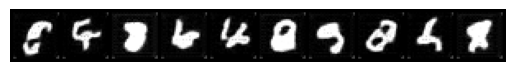

Training:  10%|▉         | 2349/23500 [02:43<23:16, 15.14it/s, epoch=10/100, loss=⠀      0.1652, lr=7.91E-04]

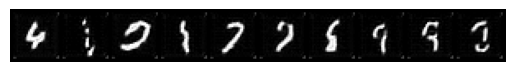

Training:  11%|█         | 2584/23500 [02:59<23:37, 14.75it/s, epoch=11/100, loss=⠀      0.1318, lr=7.72E-04]

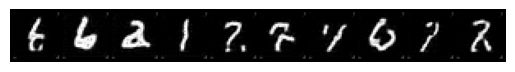

Training:  12%|█▏        | 2819/23500 [03:16<10:42, 32.21it/s, epoch=12/100, loss=⠀      0.1694, lr=7.54E-04]

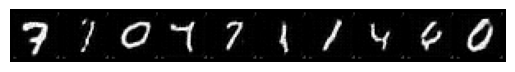

Training:  13%|█▎        | 3055/23500 [03:50<19:39, 17.34it/s, epoch=13/100, loss=⠀      0.1589, lr=7.37E-04]

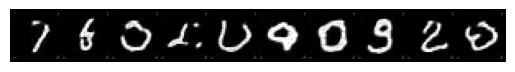

Training:  14%|█▍        | 3289/23500 [03:47<18:35, 18.12it/s, epoch=14/100, loss=⠀      0.1623, lr=7.20E-04]  

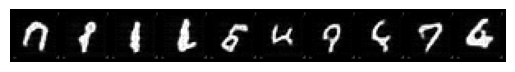

Training:  15%|█▍        | 3524/23500 [04:03<20:48, 16.00it/s, epoch=15/100, loss=⠀      0.1564, lr=7.03E-04]

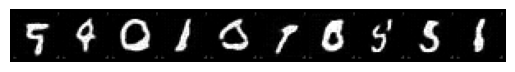

Training:  16%|█▌        | 3759/23500 [04:19<20:58, 15.69it/s, epoch=16/100, loss=⠀      0.1304, lr=6.87E-04]

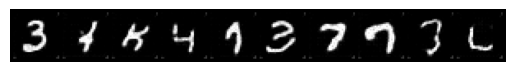

Training:  17%|█▋        | 3994/23500 [04:35<21:15, 15.30it/s, epoch=17/100, loss=⠀      0.1582, lr=6.71E-04]

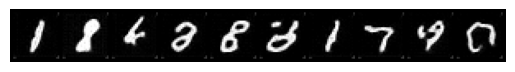

Training:  18%|█▊        | 4229/23500 [04:51<23:09, 13.87it/s, epoch=18/100, loss=⠀      0.1582, lr=6.55E-04]

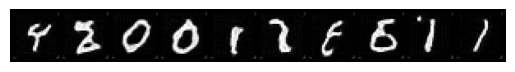

Training:  19%|█▉        | 4465/23500 [05:29<22:36, 14.04it/s, epoch=19/100, loss=⠀      0.1555, lr=6.40E-04]

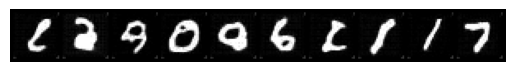

Training:  20%|█▉        | 4699/23500 [05:24<21:02, 14.89it/s, epoch=20/100, loss=⠀      0.1565, lr=6.25E-04]

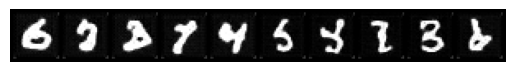

Training:  21%|██        | 4934/23500 [05:42<21:52, 14.14it/s, epoch=21/100, loss=⠀      0.1402, lr=6.10E-04]

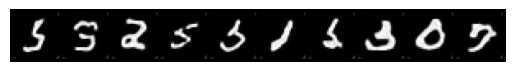

Training:  22%|██▏       | 5170/23500 [06:19<20:47, 14.69it/s, epoch=22/100, loss=⠀      0.1428, lr=5.96E-04]

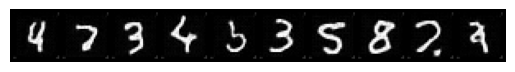

Training:  23%|██▎       | 5405/23500 [06:16<11:10, 26.98it/s, epoch=23/100, loss=⠀      0.1697, lr=5.82E-04]

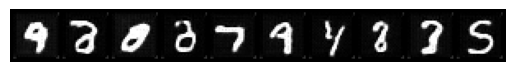

Training:  24%|██▍       | 5639/23500 [06:34<15:49:13,  3.19s/it, epoch=24/100, loss=⠀      0.1500, lr=5.69E-04]

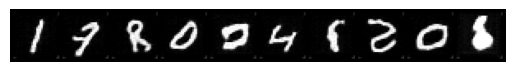

Training:  25%|██▍       | 5874/23500 [06:52<34:30,  8.51it/s, epoch=25/100, loss=⠀      0.1493, lr=5.56E-04]   

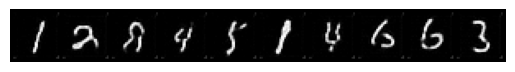

Training:  26%|██▌       | 6109/23500 [07:09<22:29, 12.89it/s, epoch=26/100, loss=⠀      0.1376, lr=5.43E-04]

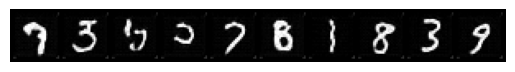

Training:  27%|██▋       | 6345/23500 [07:44<19:19, 14.80it/s, epoch=27/100, loss=⠀      0.1547, lr=5.30E-04]

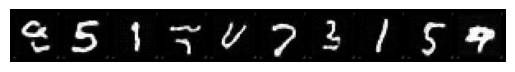

Training:  28%|██▊       | 6579/23500 [07:44<23:25, 12.04it/s, epoch=28/100, loss=⠀      0.1474, lr=5.18E-04]

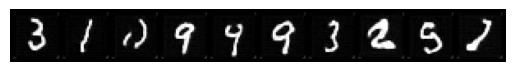

Training:  29%|██▉       | 6814/23500 [08:02<3:21:46,  1.38it/s, epoch=29/100, loss=⠀      0.1375, lr=5.06E-04]

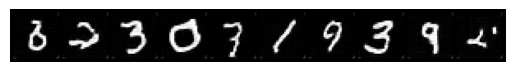

Training:  30%|██▉       | 7049/23500 [08:20<25:46, 10.63it/s, epoch=30/100, loss=⠀      0.1469, lr=4.94E-04]  

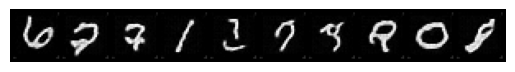

Training:  31%|███       | 7284/23500 [08:38<20:05, 13.45it/s, epoch=31/100, loss=⠀      0.1545, lr=4.83E-04]

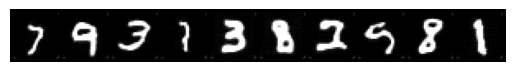

Training:  32%|███▏      | 7519/23500 [08:56<09:50, 27.07it/s, epoch=32/100, loss=⠀      0.1691, lr=4.71E-04]

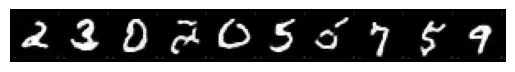

Training:  33%|███▎      | 7754/23500 [09:14<21:39, 12.12it/s, epoch=33/100, loss=⠀      0.1340, lr=4.60E-04]

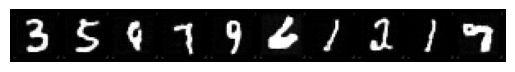

Training:  34%|███▍      | 7989/23500 [09:32<22:09, 11.66it/s, epoch=34/100, loss=⠀      0.1450, lr=4.50E-04]

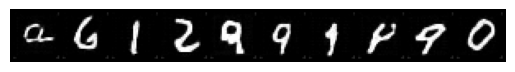

Training:  35%|███▌      | 8225/23500 [10:10<20:09, 12.63it/s, epoch=35/100, loss=⠀      0.1559, lr=4.39E-04]

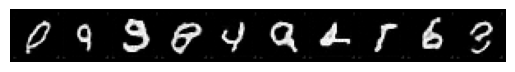

Training:  36%|███▌      | 8459/23500 [10:08<18:01, 13.90it/s, epoch=36/100, loss=⠀      0.1453, lr=4.29E-04]

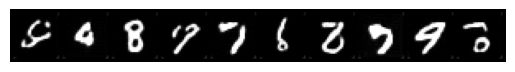

Training:  37%|███▋      | 8694/23500 [10:27<19:21, 12.75it/s, epoch=37/100, loss=⠀      0.1499, lr=4.19E-04]

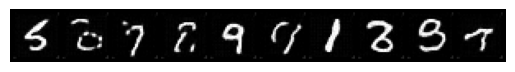

Training:  38%|███▊      | 8929/23500 [10:45<17:50, 13.61it/s, epoch=38/100, loss=⠀      0.1579, lr=4.09E-04]

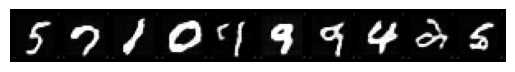

Training:  39%|███▉      | 9164/23500 [11:03<17:10, 13.91it/s, epoch=39/100, loss=⠀      0.1353, lr=4.00E-04]

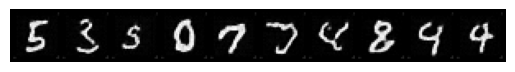

Training:  40%|███▉      | 9399/23500 [11:21<16:18, 14.42it/s, epoch=40/100, loss=⠀      0.1549, lr=3.91E-04]

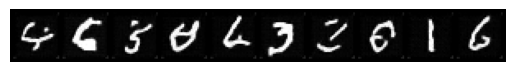

Training:  41%|████      | 9634/23500 [11:40<15:41, 14.73it/s, epoch=41/100, loss=⠀      0.1604, lr=3.82E-04]

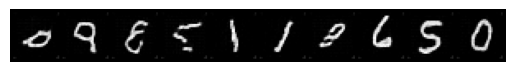

Training:  42%|████▏     | 9869/23500 [12:00<16:52, 13.46it/s, epoch=42/100, loss=⠀      0.1595, lr=3.73E-04]

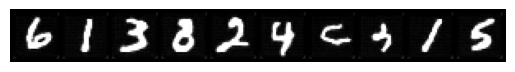

Training:  43%|████▎     | 10104/23500 [12:19<19:15, 11.59it/s, epoch=43/100, loss=⠀      0.1410, lr=3.64E-04]

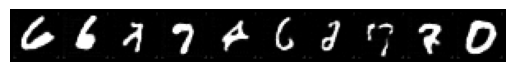

Training:  44%|████▍     | 10339/23500 [12:38<26:25,  8.30it/s, epoch=44/100, loss=⠀      0.1401, lr=3.56E-04]

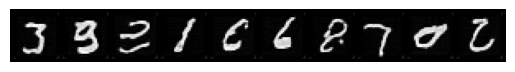

Training:  45%|████▍     | 10574/23500 [12:58<10:19, 20.87it/s, epoch=45/100, loss=⠀      0.1554, lr=3.47E-04]

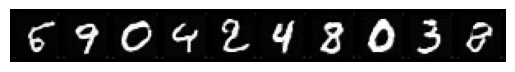

Training:  46%|████▌     | 10809/23500 [13:13<20:42, 10.21it/s, epoch=46/100, loss=⠀      0.1417, lr=3.39E-04]

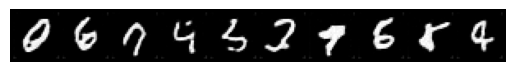

Training:  47%|████▋     | 11044/23500 [13:30<15:20, 13.52it/s, epoch=47/100, loss=⠀      0.1632, lr=3.31E-04]

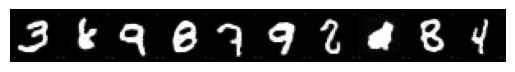

Training:  48%|████▊     | 11279/23500 [13:47<14:32, 14.01it/s, epoch=48/100, loss=⠀      0.1482, lr=3.24E-04]

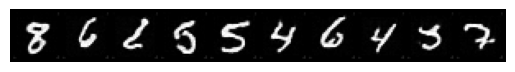

Training:  49%|████▉     | 11514/23500 [14:05<13:33, 14.73it/s, epoch=49/100, loss=⠀      0.1501, lr=3.16E-04]

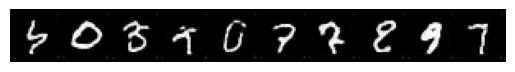

Training:  50%|████▉     | 11749/23500 [14:22<14:09, 13.83it/s, epoch=50/100, loss=⠀      0.1654, lr=3.09E-04]

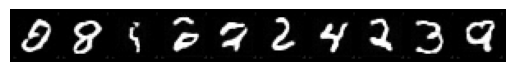

Training:  51%|█████     | 11984/23500 [14:40<13:30, 14.21it/s, epoch=51/100, loss=⠀      0.1239, lr=3.02E-04]

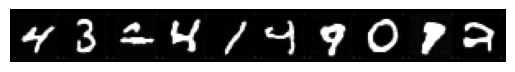

Training:  52%|█████▏    | 12219/23500 [14:58<05:56, 31.69it/s, epoch=52/100, loss=⠀      0.1297, lr=2.95E-04]

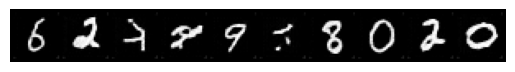

Training:  53%|█████▎    | 12454/23500 [15:17<16:21, 11.26it/s, epoch=53/100, loss=⠀      0.1587, lr=2.88E-04]

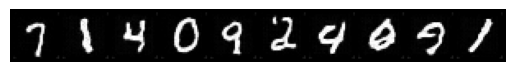

Training:  54%|█████▍    | 12689/23500 [15:37<13:27, 13.39it/s, epoch=54/100, loss=⠀      0.1350, lr=2.81E-04]

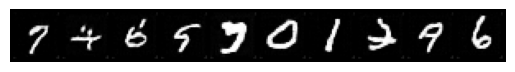

Training:  55%|█████▍    | 12924/23500 [15:57<14:45, 11.95it/s, epoch=55/100, loss=⠀      0.1477, lr=2.75E-04]

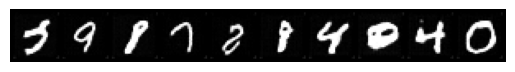

Training:  56%|█████▌    | 13159/23500 [16:18<12:01, 14.34it/s, epoch=56/100, loss=⠀      0.1457, lr=2.68E-04]

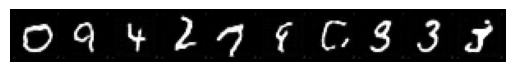

Training:  57%|█████▋    | 13394/23500 [16:40<14:18, 11.78it/s, epoch=57/100, loss=⠀      0.1368, lr=2.62E-04]

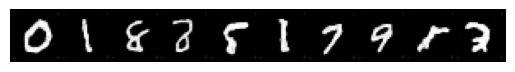

Training:  58%|█████▊    | 13629/23500 [16:58<14:33, 11.30it/s, epoch=58/100, loss=⠀      0.1724, lr=2.56E-04]

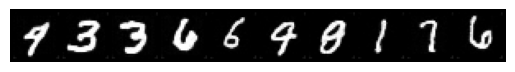

Training:  59%|█████▉    | 13864/23500 [17:15<14:13, 11.29it/s, epoch=59/100, loss=⠀      0.1438, lr=2.50E-04]

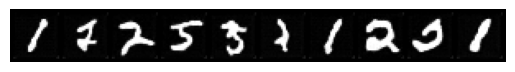

Training:  60%|█████▉    | 14099/23500 [17:32<11:48, 13.26it/s, epoch=60/100, loss=⠀      0.1556, lr=2.44E-04]

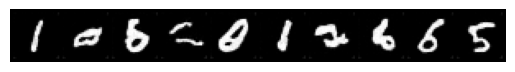

Training:  61%|██████    | 14334/23500 [17:51<11:12, 13.64it/s, epoch=61/100, loss=⠀      0.1455, lr=2.38E-04]

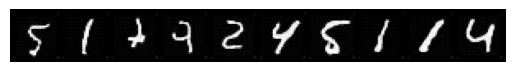

Training:  62%|██████▏   | 14569/23500 [18:09<12:02, 12.36it/s, epoch=62/100, loss=⠀      0.1526, lr=2.33E-04]

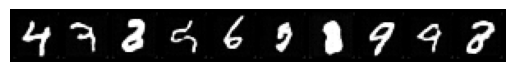

Training:  63%|██████▎   | 14804/23500 [18:27<15:23,  9.42it/s, epoch=63/100, loss=⠀      0.1585, lr=2.28E-04]

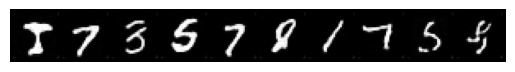

Training:  64%|██████▍   | 15039/23500 [18:44<11:54, 11.84it/s, epoch=64/100, loss=⠀      0.1516, lr=2.22E-04]

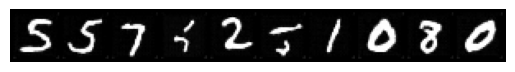

Training:  65%|██████▍   | 15274/23500 [19:03<11:26, 11.98it/s, epoch=65/100, loss=⠀      0.1553, lr=2.17E-04]

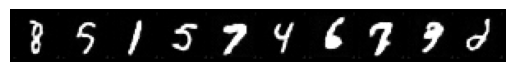

Training:  66%|██████▌   | 15509/23500 [19:21<11:00, 12.10it/s, epoch=66/100, loss=⠀      0.1514, lr=2.12E-04]

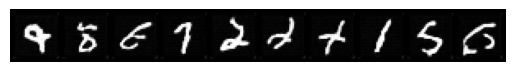

Training:  67%|██████▋   | 15744/23500 [19:40<09:30, 13.59it/s, epoch=67/100, loss=⠀      0.1480, lr=2.07E-04]

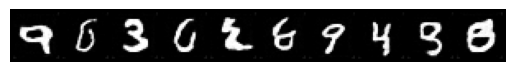

Training:  68%|██████▊   | 15979/23500 [19:59<09:38, 13.00it/s, epoch=68/100, loss=⠀      0.1416, lr=2.02E-04]

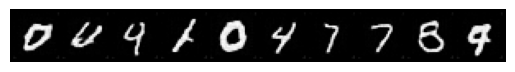

Training:  69%|██████▉   | 16214/23500 [20:20<09:37, 12.61it/s, epoch=69/100, loss=⠀      0.1688, lr=1.98E-04]

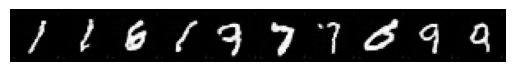

Training:  70%|███████   | 16450/23500 [21:01<05:39, 20.74it/s, epoch=70/100, loss=⠀      0.1475, lr=1.93E-04]

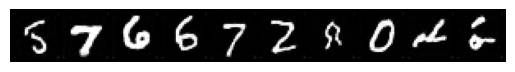

Training:  71%|███████   | 16685/23500 [21:22<06:01, 18.88it/s, epoch=71/100, loss=⠀      0.1626, lr=1.89E-04]

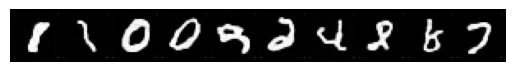

Training:  72%|███████▏  | 16919/23500 [21:17<06:05, 18.03it/s, epoch=72/100, loss=⠀      0.1598, lr=1.84E-04]

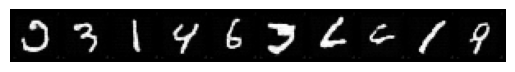

Training:  73%|███████▎  | 17154/23500 [21:34<25:15,  4.19it/s, epoch=73/100, loss=⠀      0.1094, lr=1.80E-04]  

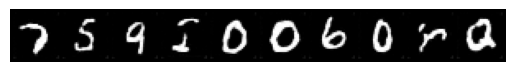

Training:  74%|███████▍  | 17390/23500 [22:12<04:10, 24.42it/s, epoch=74/100, loss=⠀      0.1596, lr=1.76E-04]

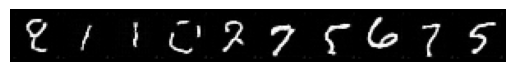

Training:  75%|███████▍  | 17624/23500 [22:07<5:04:11,  3.11s/it, epoch=75/100, loss=⠀      0.1487, lr=1.72E-04]

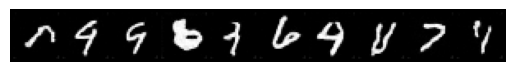

Training:  76%|███████▌  | 17859/23500 [22:24<12:37,  7.45it/s, epoch=76/100, loss=⠀      0.1510, lr=1.68E-04]  

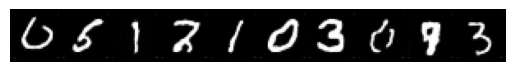

Training:  77%|███████▋  | 18094/23500 [22:40<07:48, 11.55it/s, epoch=77/100, loss=⠀      0.1645, lr=1.64E-04]

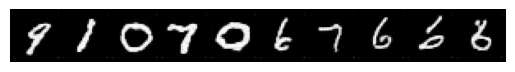

Training:  78%|███████▊  | 18329/23500 [22:57<06:48, 12.65it/s, epoch=78/100, loss=⠀      0.1379, lr=1.60E-04]

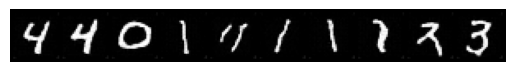

Training:  79%|███████▉  | 18564/23500 [23:15<05:59, 13.71it/s, epoch=79/100, loss=⠀      0.1471, lr=1.56E-04]

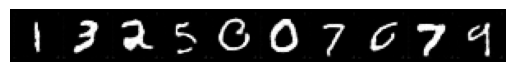

Training:  80%|███████▉  | 18799/23500 [23:33<05:52, 13.33it/s, epoch=80/100, loss=⠀      0.1297, lr=1.53E-04]

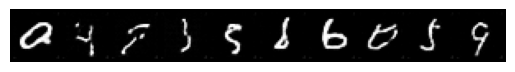

Training:  81%|████████  | 19034/23500 [23:54<05:42, 13.05it/s, epoch=81/100, loss=⠀      0.1580, lr=1.49E-04]

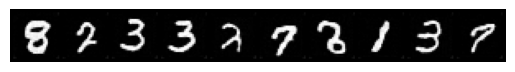

Training:  82%|████████▏ | 19269/23500 [24:17<10:42,  6.59it/s, epoch=82/100, loss=⠀      0.1479, lr=1.46E-04]

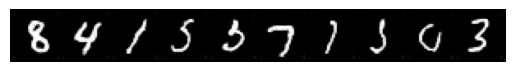

Training:  83%|████████▎ | 19505/23500 [25:02<07:28,  8.91it/s, epoch=83/100, loss=⠀      0.1622, lr=1.42E-04]

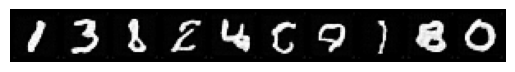

Training:  84%|████████▍ | 19739/23500 [24:58<05:53, 10.63it/s, epoch=84/100, loss=⠀      0.1398, lr=1.39E-04]

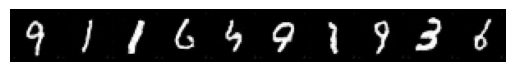

Training:  85%|████████▍ | 19974/23500 [25:15<04:27, 13.19it/s, epoch=85/100, loss=⠀      0.1271, lr=1.36E-04]

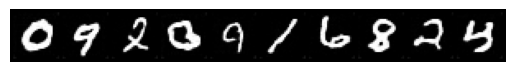

Training:  86%|████████▌ | 20209/23500 [25:33<04:30, 12.17it/s, epoch=86/100, loss=⠀      0.1566, lr=1.33E-04]

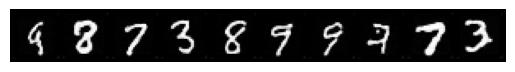

Training:  87%|████████▋ | 20444/23500 [25:53<04:05, 12.46it/s, epoch=87/100, loss=⠀      0.1438, lr=1.29E-04]

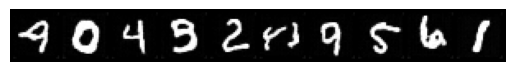

Training:  88%|████████▊ | 20679/23500 [26:13<03:39, 12.87it/s, epoch=88/100, loss=⠀      0.1480, lr=1.26E-04]

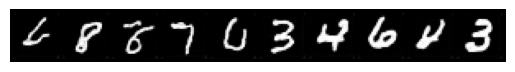

Training:  89%|████████▉ | 20914/23500 [26:50<05:36,  7.69it/s, epoch=89/100, loss=⠀      0.1469, lr=1.23E-04]

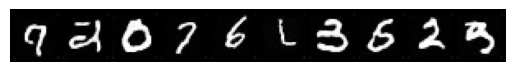

Training:  90%|████████▉ | 21149/23500 [27:06<02:53, 13.55it/s, epoch=90/100, loss=⠀      0.1390, lr=1.21E-04]

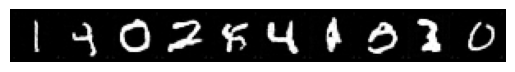

Training:  91%|█████████ | 21384/23500 [27:22<02:41, 13.07it/s, epoch=91/100, loss=⠀      0.1631, lr=1.18E-04]

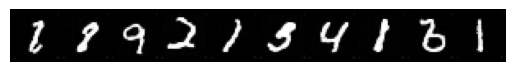

Training:  92%|█████████▏| 21619/23500 [27:38<02:10, 14.46it/s, epoch=92/100, loss=⠀      0.1464, lr=1.15E-04]

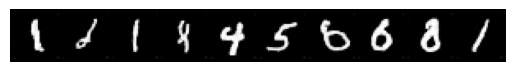

Training:  93%|█████████▎| 21854/23500 [27:56<02:00, 13.62it/s, epoch=93/100, loss=⠀      0.1524, lr=1.12E-04]

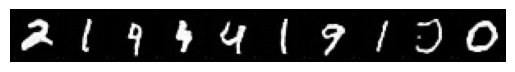

Training:  94%|█████████▍| 22089/23500 [28:14<01:38, 14.35it/s, epoch=94/100, loss=⠀      0.1642, lr=1.10E-04]

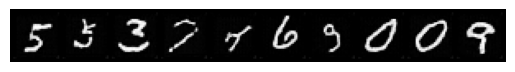

Training:  95%|█████████▍| 22324/23500 [28:33<01:23, 14.02it/s, epoch=95/100, loss=⠀      0.1481, lr=1.07E-04]

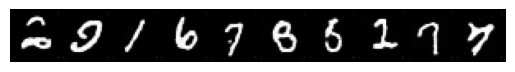

Training:  96%|█████████▌| 22559/23500 [28:53<01:14, 12.56it/s, epoch=96/100, loss=⠀      0.1427, lr=1.05E-04]

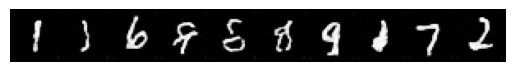

Training:  97%|█████████▋| 22795/23500 [29:12<00:39, 17.79it/s, epoch=97/100, loss=⠀      0.1576, lr=1.02E-04]

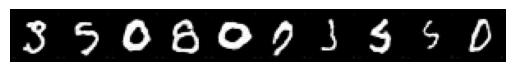

Training:  98%|█████████▊| 23029/23500 [29:32<25:05,  3.20s/it, epoch=98/100, loss=⠀      0.1464, lr=9.99E-05]

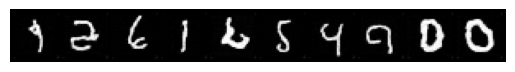

Training:  99%|█████████▉| 23265/23500 [5:17:44<01:06,  3.51it/s, epoch=99/100, loss=⠀      0.1532, lr=9.76E-05]  

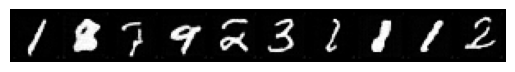

Training: 100%|█████████▉| 23499/23500 [5:17:41<00:00,  9.72it/s, epoch=100/100, loss=⠀      0.1447, lr=9.54E-05]

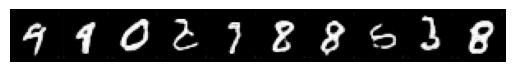

Training: 100%|██████████| 23500/23500 [5:17:44<00:00,  1.23it/s, epoch=100/100, loss=⠀      0.1447, lr=9.54E-05]


In [7]:
# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T, predict_using="x0").to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# Call training loop
train(
    model,
    optimizer,
    scheduler,
    dataloader_train,
    epochs=epochs,
    device=device,
    ema=True,
    per_epoch_callback=reporter,
)

# Save model
torch.save(
    model.state_dict(),
    f"./models/ddpm_x0_linear_none_{device}.pt",
)


In [8]:
def calculate_fid(model, dataloader, device, num_samples=10000):
    """
    Calculate the Fréchet Inception Distance (FID) score between real and generated images.

    Parameters:
        model: The generative model used to produce images.
        dataloader: DataLoader providing batches of real images.
        device: The device (CPU or GPU) to perform computations on.
        num_samples: The number of samples to use for FID calculation (default is 10,000).

    Returns:
        fid_score: The calculated FID score as a floating-point number.
    """

    # Initialize FID metric
    fid_metric = FrechetInceptionDistance(device=device)

    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: (x + 1) / 2.0),  # Map from [-1, 1] to [0, 1]
            # transforms.Grayscale(num_output_channels=3),
            transforms.Resize((299, 299)),  # Resize to 299x299 pixels
        ]
    )

    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    # Keep track of the number of processed samples
    total_fake_samples = 0
    total_real_samples = 0

    with torch.no_grad():
        # Generate and collect fake images
        while total_fake_samples < num_samples:
            batch_size = min(dataloader.batch_size, num_samples - total_fake_samples)

            # Generate fake images using the model
            fake_images = model.sample((batch_size, 28 * 28))
            # Reshape fake images to (N, 1, 28, 28) to allow for 3 channels
            fake_images = fake_images.view(-1, 1, 28, 28)
            # Map from [-1, 1] to [0, 1]
            # fake_images = (fake_images + 1) / 2
            # # Convert to 3 channels
            fake_images = fake_images.repeat(1, 3, 1, 1)

            # Resize to (N, 3, 299, 299)
            fake_images = transform(fake_images)
            fake_images = fake_images.clamp(0.0, 1.0)

            # Update FID metric with fake images
            fid_metric.update(fake_images.to(device), is_real=False)
            total_fake_samples += batch_size

        # Collect real images
        for real_images, _ in dataloader:
            batch_size = real_images.size(0)

            # Only process up to num_samples
            if total_real_samples + batch_size > num_samples:
                batch_size = num_samples - total_real_samples
                real_images = real_images[:batch_size]

            # Process real images
            real_images = real_images.view(-1, 1, 28, 28)
            # real_images = (real_images + 1) / 2  # Map from [-1, 1] to [0, 1]
            real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels
            real_images = transform(real_images)  # Resize to (N, 3, 299, 299)
            real_images = real_images.clamp(0.0, 1.0)

            # Update FID metric with real images
            fid_metric.update(real_images.to(device), is_real=True)
            total_real_samples += batch_size

            if total_real_samples >= num_samples:
                break

    # Compute FID score
    fid_score = fid_metric.compute()
    return float(fid_score)


In [78]:
# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T, predict_using="epsilon")

# Load model from checkpoint using predict_using, scheduler_method, and variance_reduction
checkpoint_path = f"./models/ddpm_epsilon_linear_none_{device}.pt"

model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

model.to(device)

# fid = calculate_fid(model, dataloader_train, device, num_samples=1280)
# print(fid)


DDPM(
  (_network): ScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (dense1): Dense(
      (dense): Linear(in_features=256, out_features=32, bias=True)
    )
    (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense2): Dense(
      (dense): Linear(in_features=256, out_features=64, bias=True)
    )
    (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense3): Dense(
      (dense): Linear(in_features=256, out_features=128, bias=True)
    )
    (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense4): Dense(
      (dense): Linear(in_features=256, out_features=256, bias=

In [79]:
def calculate_fid_2(model, dataloader, device, num_samples=10000):
    """
    Calculate the Fréchet Inception Distance (FID) score between real and generated images.

    Parameters:
        model: The generative model used to produce images.
        dataloader: DataLoader providing batches of real images.
        device: The device (CPU or GPU) to perform computations on.
        num_samples: The number of samples to use for FID calculation (default is 10,000).

    Returns:
        fid_score: The calculated FID score as a floating-point number.
    """

    # Initialize FID metric
    fid_metric = FrechetInceptionDistance(device=device)

    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: (x + 1) / 2.0),  # Map from [-1, 1] to [0, 1]
            # transforms.Grayscale(num_output_channels=3),
            transforms.Resize((299, 299)),  # Resize to 299x299 pixels
        ]
    )

    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    # Keep track of the number of processed samples
    total_fake_samples = 0
    total_real_samples = 0

    with torch.no_grad():
        # Generate and collect fake images
        while total_fake_samples < num_samples:
            batch_size = min(dataloader.batch_size, num_samples - total_fake_samples)

            # Generate fake images using the model
            fake_images = model.sample((batch_size, 28 * 28))
            # Reshape fake images to (N, 1, 28, 28) to allow for 3 channels
            fake_images = fake_images.view(-1, 1, 28, 28)
            # Map from [-1, 1] to [0, 1]
            # fake_images = (fake_images + 1) / 2
            # # Convert to 3 channels
            fake_images = fake_images.repeat(1, 3, 1, 1)

            # Resize to (N, 3, 299, 299)
            fake_images = transform(fake_images)
            fake_images = fake_images.clamp(0.0, 1.0)

            # Update FID metric with fake images
            fid_metric.update(fake_images.to(device), is_real=False)
            total_fake_samples += batch_size

        # Collect real images
        for real_images, _ in dataloader:
            batch_size = real_images.size(0)

            # Only process up to num_samples
            if total_real_samples + batch_size > num_samples:
                batch_size = num_samples - total_real_samples
                real_images = real_images[:batch_size]

            # Process real images
            real_images = real_images.view(-1, 1, 28, 28)
            # real_images = (real_images + 1) / 2  # Map from [-1, 1] to [0, 1]
            real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels
            real_images = transform(real_images)  # Resize to (N, 3, 299, 299)
            real_images = real_images.clamp(0.0, 1.0)

            # Update FID metric with real images
            fid_metric.update(real_images.to(device), is_real=True)
            total_real_samples += batch_size

            if total_real_samples >= num_samples:
                break

    # Compute FID score
    fid_score = fid_metric.compute()
    return float(fid_score)


In [80]:
print(calculate_fid_2(model, dataloader_train, device, num_samples=10000))

15.81134033203125


In [81]:
import math
import os

from torchvision.utils import save_image


In [82]:
def generate_save_samples2(
    model,
    mnist_dataloader,
    root_dir="./generated_images",
    n_samples=10000,
    batch_size=256,
    guided=False,
    w=None,
    plot=False,
):
    """
    Generate and save images from the model.
    """

    # Root directory
    class_name = "generated"
    class_dir = os.path.join(root_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Model in evaluation mode
    model.eval()

    # Calculate the number of batches needed
    num_batches = (n_samples + batch_size - 1) // batch_size  # Ceiling division

    # If guided, create an infinite iterator over the DataLoader
    if guided:
        mnist_iterator = iter(mnist_dataloader)

    with torch.no_grad():
        global_index = 0  # To keep track of the total generated images
        for batch_idx in range(num_batches):
            batch_size_curr = min(batch_size, n_samples - batch_idx * batch_size)

            if guided:
                # Get labels, reset iterator if necessary
                try:
                    data = next(mnist_iterator)
                except StopIteration:
                    mnist_iterator = iter(mnist_dataloader)
                    data = next(mnist_iterator)
                y = data[1][:batch_size_curr]
                samples = model.sample((batch_size_curr, 28 * 28), y, w)
            else:
                samples = model.sample((batch_size_curr, 28 * 28))

            samples = (samples + 1) / 2  # Map back from [-1, 1] to [0, 1]
            samples = samples.clamp(0.0, 1.0)

            for j, sample in enumerate(samples):
                save_path = os.path.join(class_dir, f"image_{global_index:05d}.png")
                save_image(sample.view(1, 28, 28), save_path)
                global_index += 1

                # Optionally, print progress
                if global_index % 100 == 0:
                    print(f"Generated {global_index} images")

In [83]:
def compute_fid(
    generated_images_dir="./generated_images",
    evaluation_images_dir="./evaluation_images",
    train_mnist=False,
    download_mnist=True,
    batch_size=256,
    device="cpu",
    eval_batches=None,
    feature_dim=2048,
):
    """
    Compute the Frechet Inception Distance (FID) between the generated images and the evaluation images.

    Parameters
    ----------
    generated_images_dir : str
        Directory containing the generated images. Default is "./generated_images".
    evaluation_images_dir : str
        Directory containing the evaluation images. Default is "./evaluation_images".
    train_mnist : bool
        Whether to use the training set of MNIST. Default is False.
    download_mnist  : bool
        Whether to download the MNIST dataset. Default is True.
    batch_size  : int
        Batch size for computing FID. Default is 256.
    device  : str
        Device to run computations on (CPU or GPU). Default is "cpu".
    eval_batches : int
        Number of batches to evaluate. Default is None.
    feature_dim : int
        Dimensionality of the feature space for Inception V3 model. Possible values are 64, 192, 768, or 2048. Default is 2048.
    Returns
    -------
    float
        Computed FID value.
    """
    if not train_mnist:
        print("Evaluation on MNIST test set...")
    else:
        print("Evaluation on MNIST training set...")

    # Image transformation (both evaluation set and generated one)
    transform_fid = transforms.Compose(
        [
            transforms.Grayscale(
                num_output_channels=3
            ),  # ensuring 3 channels for FID obj.
            transforms.ToTensor(),
        ]
    )

    # Generated sample manipulation
    # Create a dataset from the folder
    dataset = datasets.ImageFolder(generated_images_dir, transform=transform_fid)

    # Create a DataLoader from the dataset
    dataloader_gen = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    # Real data manipulation
    dataloader_eval = torch.utils.data.DataLoader(
        datasets.MNIST(
            evaluation_images_dir,
            download=download_mnist,
            train=train_mnist,
            transform=transform_fid,
        ),
        batch_size=batch_size,
        shuffle=True,
    )

    # Initializing the FID object
    fid = FrechetInceptionDistance(
        model=None,  # use default model for feature activation
        device=device,
        feature_dim=feature_dim,
    )

    if eval_batches:
        print(f"Using only {eval_batches} batches.")
        progress = eval_batches
    else:
        progress = math.ceil(10000 / batch_size)

    progress_bar1 = tqdm(range(progress), desc="Loading real data into FID object")
    progress_bar2 = tqdm(range(progress), desc="Loading generated data into FID object")

    # Loading real images to FID object
    for batch_idx, (data, _) in enumerate(dataloader_eval):
        fid.update(data, is_real=True)
        progress_bar1.set_postfix(batch=f"⠀{batch_idx:5d}")
        progress_bar1.update()
        if eval_batches is not None and batch_idx == eval_batches - 1:
            break

    # Loading generated images to FID object
    for batch_idx, (data, _) in enumerate(dataloader_gen):
        fid.update(data, is_real=False)
        progress_bar2.set_postfix(batch=f"⠀{batch_idx:5d}")
        progress_bar2.update()
        if eval_batches is not None and batch_idx == eval_batches - 1:
            break

    print("Computing FID...")
    res = fid.compute()
    print(f"FID: {res}")

    return res

In [84]:
dataloader_eval = (
    torch.utils.data.DataLoader(
        datasets.MNIST(
            "./mnist_data", download=True, train=False, transform=transforms.ToTensor()
        ),
        batch_size=batch_size,
        shuffle=True,
    ),
)

In [85]:
gen_dir = "./generated_images"

In [86]:
generate_save_samples2(model, dataloader_eval, n_samples=10000)

Generated 100 images
Generated 200 images
Generated 300 images
Generated 400 images
Generated 500 images
Generated 600 images
Generated 700 images
Generated 800 images
Generated 900 images
Generated 1000 images
Generated 1100 images
Generated 1200 images
Generated 1300 images
Generated 1400 images
Generated 1500 images
Generated 1600 images
Generated 1700 images
Generated 1800 images
Generated 1900 images
Generated 2000 images
Generated 2100 images
Generated 2200 images
Generated 2300 images
Generated 2400 images
Generated 2500 images
Generated 2600 images
Generated 2700 images
Generated 2800 images
Generated 2900 images
Generated 3000 images
Generated 3100 images
Generated 3200 images
Generated 3300 images
Generated 3400 images
Generated 3500 images
Generated 3600 images
Generated 3700 images
Generated 3800 images
Generated 3900 images
Generated 4000 images
Generated 4100 images
Generated 4200 images
Generated 4300 images
Generated 4400 images
Generated 4500 images
Generated 4600 imag

In [ ]:
compute_fid(device=device)

Evaluation on MNIST test set...


Loading real data into FID object:  40%|████      | 16/40 [00:26<00:41,  1.73s/it, batch=⠀   15]

Loading real data into FID object:  98%|█████████▊| 39/40 [01:07<00:07,  7.53s/it, batch=⠀   39]

Computing FID...


Loading generated data into FID object: 100%|██████████| 40/40 [04:38<00:00,  6.97s/it, batch=⠀   39]

FID: 15.936904907226562


tensor(15.9369, device='cuda:0')